# CS5228 Assignment 1

For code completion tasks, please write down your answer (i.e., your lines of code) between sentences that "Your code starts here" and "Your code ends here". For answers in plain text, you can refer to [this Markdown guide](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd) to customize the layout (although it shouldn't be needed). For ease of checking your answers + grading, please keep your plain text answers in blue text.

When you work on this notebook, you can insert additional code cells (e.g., for testing) or markdown cells (e.g., to keep track of your thoughts). However, before the submission, please remove all those additional cells. Thanks!

**Important:** 
* Save this Jupyter notebook as **A1_YourName_YourNUSNETID.ipynb** (e.g., **A1_BobSmith_e12345678.ipynb**) before submission!
* Submission deadline is 5 March 2023 (Sunday 11.59pm). You can submit it to Canvas under Assignments. You have 4 late days which can be used for either assignment, that extend the deadline by 24 hours each. No need to send any emails to use them, just submit late and they will be counted automatically. 

## Overview
The notebook can appear very long and verbose, but note that a lot of parts provide additional explanations, documentation, or some discussion.

* **Q1: Data Cleaning & Exploratory Data Analysis (EDA) (30 Points)**
    * 1 (a) Removing "Dirty" Records (6 Points)
    * 1 (b) Handling Missing (NaN) Values (6 Points)
    * 1 (c) Other Appropriate Data Cleaning / Preprocessing Steps (6 Points)
    * 1 (d) Handling of Categorical Attributes (4 Points)
    * 1 (e) Basic Facts about a Real-World Dataset (8 Points)
* **Q2: DBSCAN (10 Points)**
    * 2 (a) Running DBSCAN and Visualization (3 Points)
    * 2 (b) Effects of Data Manipulation on DBSCAN Results (3 Points)
    * 2 (c) Identifying Noise/Outliers with Clustering beyond DBSCAN (4 Points)
* **Q3: Clustering Algorithms (18 Points)**
    * 3 (a) Questions about K-Means (12 Points)
    * 3 (b) Interpreting Dendrograms (6 Points)
* **Q4: Association Rule Mining (12 Points)**
    * 4 (a) Compare the Runs A-D and Discuss your Observations! (4 Points) 
    * 4 (b) Compare the Runs A-D and discuss the results for building a recommendation engine! (4 Points)
    * 4 (c) Sketch a Movie Recommendation Algorithm Based on ARM (4 Points) 

## Setting up the Notebook

In [2]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, KMeans
from efficient_apriori import apriori
from src.utils import support, confidence, show_top_rules

np.set_printoptions(precision=2)

----------------

# Q1: Data Cleaning & Explorative Data Analysis (EDA) (30 Points)

For the following tasks, we consider a dataset containing information 20,000 past resale transactions of condo flats. Each record (i.e., data samples) consists of 12 attributes. The following **data description** list all attributes together with a brief description of each attribute's data type / domain:

* **transaction_id**: Unique ID of the resale transactions; an 8-digit integer number uniquely assigned to each transaction.
* **url**: Unique link to a website documenting this transaction as a string value.
* **name**: The name of the condo as a string value (e.g., "estella gardens", "eedon green").
* **type**: The type of condo as string value (e.g., "condominium", "apartment").
* **postal_district**: The postal district the condo is located in as integer value; Singapore has 28 postal districts: 1, 2, ..., 28 (cf. [here](https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm)).
* **subzone**: The subzone the condo is located in as a string value.
* **planning_area**: The planning area the condo is located in as a string value.
* **region**: The region the condo is located in as a string value.
* **date_of_sale**: The date (month & year) of the transaction as a string value (e.g., "mar-19", "oct-20").
* **area_sqft**: The size of the condo flat in square feet as a positive integer value.
* **floor_level**: The range of floors in which the flat is located in the condo as string value (e.g., "06 to 10", "11 to 15").
* **eco_category**: The eco category of the condo as a single-character string value (e.g., "A", "B", "C", "D").
* **price**: Resale price of the condo flat in Singapore Dollar as an integer value.

Additional information: Singapore has 55 planning areas; each split into multiple subzones (if interested, you can check the corresponding [Wikipedia article](https://en.wikipedia.org/wiki/List_of_places_in_Singapore)).

**Important:** In each of the following subtasks we use a slightly different version of the dataset. This allows you to focus on the specific aspects of data cleaning / data preprocessing addresses in the respective subtask.

### 1 (a) Removing "Dirty" Records (6 Points)

We argued in the lecture that almost all real-world datasets contain some form of noise that might negatively affect any applied data analysis. The very first -- and in some sense -- easiest way to identify noise is to check if all data confirms with the data description. The following code cell shows a snippet of the dataset which you will be looking at in this subtask.

In [3]:
df_condo_dirty = pd.read_csv('data/a1-condo-resale-dirty.csv')

df_condo_dirty.head()

,transaction_id,name,street,type,postal_district,subzone,planning_area,date_of_sale,area_sqft,floor_level,price
0,82953057,treasure at tampines,tampines lane,condominium,18,tampines east,tampines,jul-19,818,06 to 10,1024000
1,17139360,parc central residences,tampines street 86,executive condominium,18,tampines west,tampines,apr-21,990,11 to 15,1187000
2,22288515,martina mansions,bukit timah road,apartment,10,nassim,tanglin,jan-20,1259,01 to 05,2300000
3,80737365,the pier at robertson,mohamed sultan road,apartment,9,robertson quay,singapore river,jun-19,1044,06 to 10,2400000
4,83154310,rivercove residences,anchorvale lane,executive condominium,19,anchorvale,sengkang,oct-18,1184,16 to 20,1239100


If you check the dataset against its description, you will notice that many records are "dirty". **We define a record as "dirty" if it does not adhere to the given data description (see above)**. Such records are not guaranteed to be valid and should therefore not be used for any analysis.

**Identify 2 causes of "dirty" records and remove all corresponding records from the dataset!** Please provide your answer in the markdown cell below. Additional (simplifying) guidelines:

* Ignore missing (`NaN`) values -- that is, a record containing one or more missing values does not make this record dirty. We look at missing values in a subsequent task.
* Ignore the correctness of string values -- we do not expect you to check, e.g., if a street name contains a typo or a planning area is indeed one of the existing 55 planning areas in Singapore

**Your Answer:**

<font color='blue'>

- Dirty records can occur due to duplicate entries of previously entered records. Therefore, it will lead to many records not being unique and would skew data analysis. E.g., `transaction_id` is not unique in the given dataframe. 

- Dirty records can occur if the constraints of the given attributes is not followed. This can lead to nonsensical values being added to records. E.g., some values of `area` are non-positive integers which don't make sense in real-life.
    
</font>

Use the code cell below to actually implement your steps for removing the "dirty" records. The results should back up your answer above.

**Important:** Avoid using loops in the parts of the code you have to complete -- `pandas` is really powerful and should be your best friend here. If you use loops but the results are correct, there will be some minor deduction of points. But note that it's of course better to have a working solution using loops than having no solution at all.

In [22]:
# We first create a copy of the dataset and use this one to clean the data.
df_cleaned = df_condo_dirty.copy()

#########################################################################################
### Your code starts here ###############################################################

# Drop duplicate records such that transaction_id is unique in the resulting dataframe 
df_cleaned.drop_duplicates(inplace=True)

# Keep only those records that have postive values for area_sqft
df_cleaned = df_cleaned[df_cleaned['area_sqft'] > 0]
### Your code ends here #################################################################
#########################################################################################

print('After cleaning, there are now {} records.'.format(df_cleaned.shape[0]))

After cleaning, there are now 18799 records.


**Important:** We do not provide an expected output regarding the number of records after the cleaning step as there is some wiggle room regarding the performed steps which would affect this result. As such, even if two solutions are correct, they do not necessarily yield the same number of records.

### 1 (b) Handling Missing (NaN) Values (6 Points)

Many to most traditional data mining algorithms do not like missing (NaN) values and will throw an error if missing values are present. We therefore have to address missing values and get rid of them. On the other hand, we want to preserve as much of our dataset as possible, so we need to be smart about that. In this subtask, you are provided with a version of our condo resale dataset that contains missing values but is otherwise clean -- so it is all about the `NaN` values here.

Let's load the dataset and have a quick look -- the attributes are the same as before:

In [23]:
df_condo_nan = pd.read_csv('data/a1-condo-resale-nan.csv')

df_condo_nan.head()

,transaction_id,url,name,street,type,postal_district,subzone,planning_area,date_of_sale,area_sqft,floor_level,eco_category,price
0,95103981,http://condo-sg.com/alex-residences-3570,alex residences,alexandra view,apartment,3,redhill,bukit merah,oct-21,883,01 to 05,A,1595880.0
1,69374014,http://condo-sg.com/the-rivervale-4160,the rivervale,rivervale link,executive condominium,19,rivervale,sengkang,jul-17,1313,06 to 10,A,900000.0
2,54377409,http://condo-sg.com/parc-palais-5143,parc palais,hume avenue,condominium,21,hillview,bukit batok,sep-21,1389,01 to 05,A,1810000.0
3,64749050,NaN,hedges park condominium,flora drive,condominium,17,flora drive,pasir ris,may-19,484,01 to 05,A,565000.0
4,18136469,NaN,kingsford waterbay,upper serangoon view,apartment,19,kangkar,hougang,may-21,678,06 to 10,A,875000.0


Since your decision for handling `NaN` values might depend in the data mining task, assume in the following that you want to use this dataset to **create a regression model to predict the resale price** from the attributes of a transaction. Of course, there will be no need to actually create such a model here :).

**Identify all `NaN` values in the dataset and handle them appropriately!** After this preprocessing, the resulting dataset should no longer contain any `NaN` values. Additional (simplifying) hints or guidelines:

* You can use the `.info()` function of a pandas dataset to get info about its `NaN` values.
* You do not need to consider external knowledge (i.e., information coming from outside this dataset), or sophisticated solutions such as [`sklearn.impute.KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). These can be very useful in practice (and maybe for your project), but their application requires certain assumptions to hold for good results. This is beyond the scope of this assignment.
* Remove column `url`; one can argue that this is just a label and has no information for any analysis
* Remove all records where `price` or `area_sqft` is `NaN`; these attributes are vey important for creating the model and there's no obvious way to reliably derive it
* Derive missing `planning_area` values from subzone values; there's a clear mapping from a subzone to the corresponding planning area

**Your Answer:**

<font color='blue'>

- Remove `url` as it is not important for creating a regression model to predict the resale of price since it's only a label with no imapct on the price of the condos.

- Remove all records where `price` is `NaN` as it is a very important attribute for model creating. Another way could have been to polpulate these `NaN` values with the average `price` of all records. In that case, it wouldn't necessarily be the true value but we would be preserving as much of our dataset as possible with a slight bias. 

- Derive missing `planning_area` values from subzone values; there's a clear mapping from a subzone to the corresponding planning area.
    
</font>


Use the code cell below to actually implement your steps for handling `NaN` values. The results should back up your answer above.

**Important:** Avoid using loops in the parts of the code you have to complete -- pandas is really powerful and should be your best friend here. If you use loops but the results are correct, there will be some minor deduction of points.

In [45]:
# We first create a copy of the dataset and use this one to clean the data.
df_no_nan = df_condo_nan.copy()

#########################################################################################
### Your code starts here ###############################################################

# Drop the column `url`
df_no_nan = df_no_nan.drop(columns=['url'])

# Drop records where price is NaN
df_no_nan.dropna(subset=['price'], inplace=True)

# Map NaN values in planning_area using subzone
df_temp = df_no_nan.dropna(subset=['planning_area'])
subzone_map = dict(list(zip(df_temp.subzone, df_temp.planning_area)))
df_no_nan['planning_area'] = df_no_nan['subzone'].map(subzone_map)

### Your code ends here #################################################################
#########################################################################################

print('After handling missing values, there are now {} records.'.format(df_no_nan.shape[0]))
print('Number of records with an NaN for any attribute: {}'.format((df_no_nan.isna().sum(axis=1) > 0).sum()))

After handling missing values, there are now 19033 records.
Number of records with an NaN for any attribute: 0


**Important:** We do not provide an expected output regarding the number of records after this preprocessing step as there is some wiggle room regarding the performed steps which would affect this result. However, the number of records with `NaN` values should be 0.

### 1 (c) Other Appropriate Data Cleaning / Preprocessing Steps (6 Points)

Identifying "dirty" records and missing data are two very fundamental and generally rather systematic steps as part of data cleaning / data preprocessing. However, as we saw in the lecture using some examples, there are many other issues with the dataset that can be considered noise and thus potentially negatively affecting any data analysis. So the more noise we can remove, the more likely we can expect meaning analysis results.

For this subtask, we use a version of our condo resale dataset **with no "dirty" records or missing data**! Let's have a look:

In [46]:
df_condo_others = pd.read_csv('data/a1-condo-resale-others.csv')

df_condo_others.head()

,transaction_id,url,name,type,postal_district,subzone,planning_area,date_of_sale,area_sqft,floor_level,eco_category,price
0,72606080.0,https://condo-sg.com/amber-park-4904,amber park,condominium,15,marine parade,marine parade,apr-21,678,16 to 20,A,1679130
1,62765491.0,https://condo-sg.com/braddell-view-5318,braddell view,apartment,20,toa payoh west,Toa Payoh,oct-20,1701,01 to 05,A,1255000
2,65584694.0,https://condo-sg.com/tangerine-grove-2635,tangerine grove,condominium,19,tai seng,hougang,nov-18,947,01 to 05,A,1130000
3,16401608.0,https://condo-sg.com/goldenhill-park-condomini...,goldenhill park condominium,condominium,20,lorong chuan,serangoon,mar-21,1313,01 to 05,A,2000000
4,53975895.0,https://condo-sg.com/kingsford-waterbay-1085,kingsford waterbay,apartment,19,kangkar,hougang,may-17,883,06 to 10,A,1030000


**Your boss points out the following data quality issues; please explain what the issues are and how you would deal with them:** Please provide your answer in the markdown cell below list necessary steps with a justification for your decision. You may want to create a cell below to explore the data, which you can delete afterwards.

* Outliers in `area_sqft`;
* Inconsistent naming in `planning_area`;

Additional (simplifying) guidelines:
* You should still assume that we want to use this dataset to create a model for predicting the resale price of a flat based on its attributes. The choice of data mining task can affect your decision for what cleaning / preprocessing steps to apply.
* There is no need to consider external knowledge. For example, you do not have to check if a value for `subzone` is indeed an existing subzone of Singapore.
* There is no need for you to implement any processing steps! Most important are your justifications for your decisions.

**Your Answer:**


<font color='blue'>

1. Problem 1:
    - `planning_area` has inconsitent naming convention. Some records are lowercase, while others are not even if the area is same. For e.g., `marine parade` and `Marine Parade`.

- Solution 1:
    - Convert all values of `planning_area` to lowercase to make the naming consistent.
    - Alternatively, since the model we are creating is a regression model based on resale values and prices, `planning_area` column does not add much value to our model creation task. Moreover, since we saw before that there is a clear mapping from `subzone` to `planning_area`, we can term `planning_area` to be a redundant column and safely remove the column `planning_area` entirely without loss of any important data for model building.
    
2. Problem 2:
    - `area_sqft` has values ranging from `1` to `8956` sq ft with 50% values above ~`950 sqft` and a standard deviation of `574 sq ft`. This is a very diverse range and skews the data distribution due to outliers, i.e., very low or very high values. 

- Solution 2:
    - Remove records that have area_sqft of less than `500 sqft` since 25% of the data is above 667 sqft and the standard deviation is 574 sqft. This will reduce the variance of the resulting area_sqft column, thereby removing noisy points. 
    - We can also remove records above a certain threshold (like above 7000 sqft) by visualizing how many points are there and eliminate if they are too few.
</font>

### 1 (d) Handling Categorical Attributes (4 Points)

Many to most data mining algorithms require all input features / attributes to be numerical. Our dataset with transactions resales of condo flats contains attributes that are not all numerical. As such, assuming we indeed want to utilize them, we need to convert those attributes into numerical ones. Regarding encoding techniques, we covered [One-Hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) in the lecture. For variables with too many categories (e.g. >30) to be suitable for one-hot encoding, a common alternative is [Target Encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html), which replaces each category with a numeric value (roughly, the average value of the target variable for that particular category).

Some common choices for how to handle a categorical attribute include
* **Drop**: to drop a variable if it is not likely to be useful for modelling
* **Ordinal**: treat it as an ordinal variable
* **One-Hot Encoding**: encode each of its categories into a binary attribute
* **Target Encoding**: encoder the entire variable into a single numerical attribute

**For each of the 4 above choices, select *1* variable that you believe is suitable to be handled using that choice, and justify.**

There is no single correct answer for this task; it's your justification that matters. Again, assume that we want to create a regression model to predict the resale price of a flat based on the other features.

**Your Answer:**

<font color='blue'>

- **Drop**: `eco_category` can be dropped since it has only one distinct value for all records and therefore does not add any additional insight to invidual records.
    
- **Ordinal**: `floor_level` has 15 distinct values that are in the form of a range (e.g., `16 to 20`). Floors can be treated as ordinal data as they are always ranked in some natural order or hierarchy, for e.g., Floors `01 to 05` are always below Floors `06 to 10`. 
    
- **One-Hot Encoding**: `type` has 6 distinct values and thus can be represented using a 1-hot encoded vector since the vector size would be small. Also, there is not prior knowledge as to say a condominium having more preference over an apartment. Hence, all values can be represented with equal weightage, i.e., 1 in the vector. 
    
- **Target Encoding**: `subzone` has 191 distinct values. Hence, there are too many values suitable for 1-hot encoding and can be replaced with corresponding target encoding. Moreover, since in target encoding, features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data, we might get some added insight about the relationship between resale values and the subzones the flats are in.
    
</font>

### 1(e) Basic Facts about a Real-World Dataset (8 Points)

The following tasks are about getting basic insights into the Condo Resale Prices dataset. As the data preprocessing steps you choose to perform might affect the results of this task, we will use a modified version here. Note that this version contains 20,000 listing of condo resale transactions and does **not** contain any "dirty" records. This is to ensure that everyone uses the same data. This helps marking your solutions as we know which results to expect.

In [58]:
df_condo_facts = pd.read_csv('data/a1-condo-resale-facts.csv')

df_condo_facts.head()

,transaction_id,url,name,type,postal_district,subzone,planning_area,date_of_sale,area_sqft,floor_level,eco_category,price
0,13685562,https://condo-sg.com/the-tapestry-9447,the tapestry,condominium,18,tampines west,tampines,apr-18,700,01 to 05,A,931500
1,53321107,https://condo-sg.com/the-interlace-4916,the interlace,condominium,4,depot road,bukit merah,jun-17,1044,11 to 15,A,1200000
2,10676043,https://condo-sg.com/d'leedon-5888,d'leedon,condominium,10,farrer court,bukit timah,aug-21,635,11 to 15,A,1100000
3,88341877,https://condo-sg.com/mulberry-tree-4753,mulberry tree,apartment,11,moulmein,novena,may-18,667,01 to 05,A,1100000
4,69569828,https://condo-sg.com/ue-square-3203,ue square,apartment,9,robertson quay,singapore river,apr-18,1206,01 to 05,A,1950000


Please complete the table below by answering the given questions. Use the code cell below the table to actually implement your steps that enabled you to answer the questions. There is no need for a fancy layout for any print statement; it's only important that the result is clear.

**Your Answer:**

This is a markdown cell. Please fill in your answers for (1)-(6). Answers (1)-(4) are worth 1 Point each; Answer (5)-(6) are worth 2 Points.

| No. | Question                                                                                                   | Answer       |
|-----|------------------------------------------------------------------------------------------------------------|--------------|
| (1)  | What is the date (month & year) of the earliest transaction? | <font color='blue'>dec-16</font> |
| (2)  | For each `type`, how many transactions are in the dataset?  | <font color='blue'> condominium: 9688, apartment: 8038, executive condominium: 2255, strata terrace: 14, strata semi-detached: 3, strata detached: 2</font> |
| (3)  | What is the planning area with the most transactions? List the name of the planning area and the number of transactions!  | <font color='blue'>bedok with 1307 transactions. The rest are shown in the output of the codecell below.</font> |
| (4)  | What is the correlation between the resale *price* and *area_sqft*? | <font color='blue'>0.735</font> |
| (5)  | Which transaction in postal district 11 had the highest price-to-area ratio (i.e., the highest price per square foot)? List the name of the condo and the price per square foot (rounded to 2 decimals)| <font color='blue'>Name: pullman residences newton, Price per square foot: 3083.96 </font> |
| (6)  | What is the number of transactions where the apartment was between the 51st floor (inclusive) and 60th (inclusive) floor?  | <font color='blue'>23</font> |

In [127]:
#########################################################################################
### Your code starts here ###############################################################
# 1.
def convert_date(x):
    m, y = x.split('-')
    return m + '-20' + y 

dos = df_condo_facts['date_of_sale'].apply(convert_date)
dos = pd.to_datetime(dos).sort_values()
# print earliest 5 transactions
print(dos[:5])
print("----------------------")

# 2. 
print(df_condo_facts['type'].value_counts())
print("----------------------")

# 3.
print(df_condo_facts['planning_area'].value_counts())
print("----------------------")

# 4.
print(df_condo_facts['price'].corr(df_condo_facts['area_sqft']))
print("----------------------")

# 5.
df = df_condo_facts[df_condo_facts['postal_district'] == 11]
df['price_by_area'] = round(df['price'] / df['area_sqft'], 2)
highest_price_to_area = df['price_by_area'].max()
result = df[df['price_by_area'] == highest_price_to_area]
print(result)
print("----------------------")

# 6.
def floor(x):
    start, _, end = x.split()
    if start == '51' or end == '60':
        return True
    return False
df = df_condo_facts[df_condo_facts['floor_level'].apply(floor)]
print(len(df))

### Your code ends here #################################################################
#########################################################################################

16608   2016-12-01
13170   2017-01-01
3206    2017-01-01
10101   2017-01-01
4691    2017-01-01
Name: date_of_sale, dtype: datetime64[ns]
----------------------
condominium              9688
apartment                8038
executive condominium    2255
strata terrace             14
strata semi-detached        3
strata detached             2
Name: type, dtype: int64
----------------------
bedok               1307
geylang             1197
hougang             1196
clementi            1173
tampines            1164
queenstown          1111
bukit timah          984
sengkang             957
pasir ris            888
bukit merah          850
toa payoh            668
serangoon            640
novena               621
downtown core        530
kallang              528
bukit batok          525
sembawang            498
marine parade        481
river valley         480
yishun               472
bishan               443
tanglin              418
choa chu kang        403
punggol              402
bukit panjan

/var/folders/34/8mvn2xt55n3b4rqrvkp4w66c0000gn/T/ipykernel_8119/3752091834.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(dos[:5])
/var/folders/34/8mvn2xt55n3b4rqrvkp4w66c0000gn/T/ipykernel_8119/3752091834.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_by_area'] = round(df['price'] / df['area_sqft'], 2)


---

# Q2: DBSCAN (10 Points)

In Section 1 we focused on addressing any "obvious" noise a given dataset may contain. Obvious noise is not well defined, but in general it's this kind of noise that can be identified by simple analysis (e.g., looking at the domains of attributes, or simple statistics such as the distribution/histogram). However, some noise is more difficult to detect. Some outliers can only be identified as such when looking at the combination of different data points. Looking at individual attributes / features does not suffice here.

An outlier refers to some record (i.e., data samples) that is very different compared to most other records. Next we see how we can utilize DBSCAN for this task. DBSCAN is a clustering algorithm with an explicit notion of noise points, i.e., data points that are dissimilar to data points that form clusters.

We use in this section a small toy dataset -- 70 records, 2 numeric attributes -- for easy testing and visualization.

In [128]:
X_dbscan_toy = pd.read_csv('data/a1-dbscan-toy-dataset.txt', header=None, sep=' ').to_numpy()

print('The shape of X_dbscan_toy is {}'.format(X_dbscan_toy.shape))

The shape of X_dbscan_toy is (70, 2)


### 2(a) Running DBSCAN and Visualization (3 Points)

**Run scikit-learn's implementation of [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on this dataset**. Use `eps=0.1` and `min_samples=10` as values for the two main input parameters for DBSCAN that specify the minimum "density" of clusters.

The scikit-learn output contains a `labels_` variable, where, noise points are labeled with `-1`, while all points belonging to clusters are labeled with `0`, `1`, `2`, etc. So we can easily find the indices of all the points labeled as noise.

Your output of running `DBSCAN(...)` should be saved as a variable called `dbscan_clustering`, and you should construct a binary vector (of length 70) called `is_noise`, where `True` indicates noise points. (As long as the subsequent visualization works, it indicates that you have done it correctly).

In [137]:

#########################################################################################
### Your code starts here ###############################################################

# Run DBSCAN(...); the output should be saved in a variable called `dbscan_clustering`, 
# and also construct a binary variable called `is_noise`, where True indicates noise points.
dbscan_clustering = DBSCAN(eps=0.1, min_samples=10).fit(X_dbscan_toy)

def check_noise(x):
    return True if x == -1 else False

is_noise = np.array([check_noise(x) for x in dbscan_clustering.labels_])

### Your code ends here #################################################################
#########################################################################################

If you have done it correctly, the following code should successfully plot the clusters and outliers:

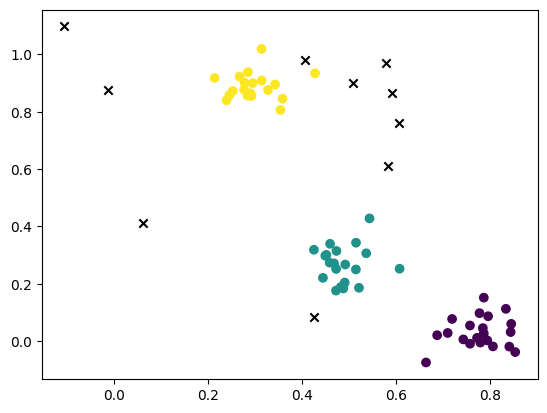

In [138]:
# Noise points plotted as black crosses; other points plotted as circles with color indicating cluster
plt.figure()
plt.scatter(X_dbscan_toy[~is_noise,0], X_dbscan_toy[~is_noise,1], c=dbscan_clustering.labels_[~is_noise], marker='o')
plt.scatter(X_dbscan_toy[is_noise,0], X_dbscan_toy[is_noise,1], c='black', marker='x')
plt.show()

### 2 (b) Effects of Data Manipulation on DBSCAN Results (3 Points)

Assume you have a $d$-dimensional dataset `X` in the Euclidean space, i.e., each data point as $d$ numerical features (with each feature value in the interval $[0, 1]$). After running DBSCAN over `X`, you get some clustering (again, we only assume it's not only noise). Now you create a new dataset `X_new` by multiplying all data points by 10 afterwards adding 100 to all data points (in Python, assuming X is a NumPy array this can simply be done by `X_new = X * 10 + 100`). Now you can run DBSCAN over `X_new`.

**Explain how you have to change the parameters of DBSCAN for `X_new` to produce equivalent output to the original results on `X`!**. You can ignore any nondeterminism (e.g. border points being assigned to different clusters, as discussed in lecture), or duplicates.

**Your Answer:**

<font color="blue">

- `min_samples` will not change as transforming the data linearly will not change the relative orientation of data points.
    
- `eps` will have to be increased by 100 as now the distances have inflated by 100, i.e., `eps_new` = `eps * 100`
</font>

### 2 (c) Identifying Noise/Outliers with Clustering beyond DBSCAN (4 Points)

Apart from DBSCAN, we also covered two other important clustering algorithms: K-Means and (agglomerative) hierarchical clustering. For all three clustering algorithms we looked in detail into their approach, and also discussed the individual strengths, weaknesses, and limitations. Particularly we saw that of these three algorithms, only DBSCAN has this explicit notion of noise points. But what about K-Means and hierarchical clustering?

**Explain if K-Means and/or hierarchical clustering can potentially be utilized to identify noise/outliers in a dataset!** If your answer for an algorithm is "No", please provide a brief justification. If your answer for an algorithm is "Yes", provide a brief sketch (no pseudo code required; a basic description will do) how to use the algorithm for noise/outlier detection.

**Your Answer:**

<font color="blue">
   
1. Yes, k-means algorithm can be used for noise or outlier detection in some cases by setting a threshold for the distance between each data point and its nearest cluster center. Any data points that are further away than this threshold will be considered outliers.

Sketch:
1. Choose the number of clusters (k).
2. Fit the k-means algorithm to the data.
3. Calculate the distance between each data point and its nearest cluster center.
4. Determine a threshold for the distance beyond which a data point is considered an outlier.
5. All data points further away than this threshold are marked as outliers.
   
However, if the data has a lot of noise or if some of the clusters are more sparse than the others, then K-Means may not work since the distance threshold is absolute. Also, since K-Means' performance greatly depends on initialization of thr cluster centres, we should do this outlier detection with different initializations in order to ensure high confidence and stable results.
    
2. Yes, hierarchical clustering can also be used for outlier detection in some cases, i.e., if some of the clusters are extremely sparse and have very low density.

Sketch:
1. Choose a linkage method and a distance metric.
2. Fit the hierarchical clustering algorithm to the data.
3. Identify clusters in the dendogram that have very few members, or individual points that are well separated from other clusters.
4. Determine a threshold for the size of a cluster or for the distance between a data point and the nearest cluster. Any clusters with fewer members or data points that are further away than this threshold can be considered outliers.
    
However, hierarchical clustering is sensitive to the choice of linkage method and the distance metric. Hence, different combinations should be tried in order to get high confidence results for outliers. 
    
**In both the cases, the algorithms in itself are sensitive to outliers but with some additional heuristics, outliers can be identified upto a certain extent.** 
</font>

---

# Q3: Clustering Algorithms (18 Points)

### 3 (a) Questions about K-Means (12 Points)

In the table below are 6 statements that are either True or False. Complete the table to specify whether a statement is True or False, and provide a brief explanation for your answer (Your explanation is more important than a simple True/False answer).

This is a markdown cell. Please fill in your answers for (1)~(6).

| No. | Statement                                                                                                   | True or False?       | Brief Explanation |
|-----|------------------------------------------------------------------------------------------------------------|--------------| ------- |
| (1)  | When using K-Means with K-Means++, then centroids are at all times at the position of existing data points | <font color="blue">F</font> | <font color="blue"> The initial centroids are existing data points but they may change in the next iterations since centroids are then calculated by averaging the distances within a cluster.</font> 
| (2)  | K-Means++ ensures that the result will not include any empty clusters. | <font color="blue">T</font> | <font color="blue">Since the initialization step involves centroid selection from the existing data points, there would always be a cluster with atleast 1 point in it.</font> 
| (3)  | K-Means, independent of the initialization method, will always converge to a local minimum (note: the global minimum is also counted as a local minimum) | <font color="blue">T</font> | <font color="blue">K-Means can be viewed as an objective minimization problem where we minimize the WCSS loss function, which is strictly decreasing with a finite number of clusters.</font> 
| (4)  | K-Means++ will always converge to the global optimum. | <font color="blue">F</font> | <font color="blue">K-Means++'s initialization strategy can reduce the chances of the algorithm getting stuck in a suboptimal solution, but it does not eliminate the possibility of convergence to a local optimum.</font> 
| (5)  | K-Means++ initialization is more costly than a random initialization of the centroids but generally converges faster. | <font color="blue">T</font> | <font color="blue">The initialization is costlier since it assigns next centres based on the probability proportional to square of distance to its closest center which requires additional computational cost. However, this initialization leads to better spread out centres thereby enabling faster convergence.</font> 
| (6)  | K-Means is insensitive to data normalization/standardization -- that is, for the same $k$ and the same initial centroids, K-Means will yield the same clusters where the data is normalized/standardized or not. | <font color="blue">T</font> | <font color="blue">K-Means only depends on the relative distance between data points and hence if all the data points are normalized/standardized, then it has no impact on the relative distances between points since it remains the same.</font> |

### 3 (b) Interpreting Dendrograms (6 Points)

We saw in the lecture that dendrograms are a meaningful way to visualize the hierarchical relationships between the data points with respect to the clustering. Properly interpreting is important to get a correct understanding of the underlying data.

Below are the plots of 6 different datasets labeled A-F. Each dataset contains 30 data points, each with two dimensions.

<img src="data/a1-agnes-data-labeled.png">

Below are 6 dendrograms labeled 1-6. These dendograms show the clustering using **(Agglomerative) Hierarchical Clustering with Single Linkage** for the 6 datasets above, but in a random order.

<img src="data/a1-agnes-dendrogram-labeled.png">

**Find the correct combinations of datasets and dendrograms** -- that is, find for each dataset the corresponding dendrogram! Give a brief explanation for each decision and complete the table below.

**Your Answer:**

| Dataset | Dendrogram | Brief Explanation |
| ---  | ---   | ---                  |
| **A**    | <font color="blue">6</font> | <font color="blue">There are 2 outliers that are represented by the 2 isolated clusters on extreme right which finally merge with the bigger (and more dense) cluster.</font> |
| **B**    | <font color="blue">1</font> | <font color="blue">B has an extremely dense cluster with most of the 30 points in it. This is represented by the isolated clusters forming 1 big cluster in the dendrogram. Finally the 2 outliers merge with this dense cluster to form 1 final cluster.</font> |
| **C**    | <font color="blue">5</font> | <font color="blue">C has equidistant from 1 point in the middle. This is represented by the final isolated cluster point on the extreme right which merges with the circular cluster(represented by the 2nd most high level cluster in the dendrogram).</font> |
| **D**    | <font color="blue">3</font> | <font color="blue">There are 2 clear clusters shown by the semicircles. These are represented by the 2 isolated dendrograms which is finally joined by a single linkage. This linkage is the joins both the semi circles using minimum distance point.</font> |
| **E**    | <font color="blue">2</font> | <font color="blue">The points in the cluster E are more or less uniformly random. The dendrograms show clusters formed by 2 points that merge to make uniform clusters of equally spaced linkages. These 3 equally spaced clusters (or isolated dendrograms) merge into 1 final cluster.</font> |
| **F**    | <font color="blue">4</font> | <font color="blue">F has 3 distinct clusters shown by 3 isolated dendrograms that are finally merged into 1 big cluster on higher levels using the single linkage.</font> |

---

# Q4: Association Rule Mining (12 Points)

Next, we focus on the **Apriori Algorithm for finding Frequent Itemsets**.


#### Toy Dataset

The following dataset has 5 transactions and 6 different items. The format is a list of tuples, where each tuple represents the set of items of an individual transaction. This format can also be used as input for the `efficient-apriori` package.

In [141]:
transactions_demo = [
    ('bread', 'yogurt'),
    ('bread', 'milk', 'cereal', 'eggs'),
    ('yogurt', 'milk', 'cereal', 'cheese'),
    ('bread', 'yogurt', 'milk', 'cereal'),
    ('bread', 'yogurt', 'milk', 'cheese')
]

#### Example of running the `efficient-apriori` package  (nothing for you to do here!)

We run the apriori algorithm over the demo data:

In [142]:
_, rules = apriori(transactions_demo, min_support=0.4, min_confidence=1.0)

for r in rules:
    print('Rule [{} => {}] (support: {}, confidence: {}, lift: {})'.format(r.lhs, r.rhs, r.support, r.confidence, r.lift))


Rule [('cereal',) => ('milk',)] (support: 0.6, confidence: 1.0, lift: 1.25)
Rule [('cheese',) => ('milk',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('cheese',) => ('yogurt',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('bread', 'cereal') => ('milk',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('cereal', 'yogurt') => ('milk',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('cheese', 'yogurt') => ('milk',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('cheese', 'milk') => ('yogurt',)] (support: 0.4, confidence: 1.0, lift: 1.25)
Rule [('cheese',) => ('milk', 'yogurt')] (support: 0.4, confidence: 1.0, lift: 1.6666666666666667)


### Recommending Movies using Association Rule Mining (ARM)

In this task, we look into using Association Rule Mining for recommending movies -- more specifically, recommending movies on physical mediums (Blu-ray, DVD, etc.), assuming that is still a thing nowadays :).

**Dataset.** We use a popular movie ratings dataset from [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains user ratings for movies (1-5 stars, incl. half stars, e.g., 3.5). Specifically, we use the [MovieLens 1M Dataset](https://grouplens.org/datasets/movielens/1m/) containing 1 Million ratings from ~6,000 users on ~4,000 movies and was released February 2003 -- so do not expect any recent Marvel movies :).

While there are more sophisticated recommendation algorithms -- and we will look into those in a later lecture -- here we focus on Association Rules. We convert this rating dataset into a transaction dataset, where a transaction represents all the movies a user has purchased. We already did this for you making the following assumption: A User has purchased all the movies s/he gave the highest rating. For example, if User A gave a highest rating of 4.5 to any movie, A has purchased all movies A rated with 4.5. This is certainly a simplifying assumption, but perfectly fine for this task here.

Let's have a quick look at the data. First, we load the ids and names of all movies into a dictionary. We need this dictionary since our transactions (i.e., the list of movies a user has bought) contains the ids and not the names of the movies. So to actually see the names of movies in the association rules, we need this way to map from a movie's id to its name.

In [149]:
# Read file with movies (and ids) into a pandas dataframe
df_movies = pd.read_csv('data/a1-arm-movies.csv', header=None)
# Convert dataframe to dictionary for quick lookups
movie_map = dict(zip(df_movies[0], df_movies[1]))
# Show the first 5 entries as example
for movie_id, movie_name in movie_map.items():
    print('{} -> {}'.format(movie_id, movie_name))
    if movie_id >= 5:
        break

1 -> Toy Story
2 -> Jumanji
3 -> Grumpier Old Men
4 -> Waiting to Exhale
5 -> Father of the Bride Part II


No we can load the transactions. Again, a transaction is a user's shopping history, i.e., all the movies the user has bought. 

In [150]:
shopping_histories = []

# Read shopping histories; each line is a comma-separated list of the movies (i.e., their ids!) a user bought
with open('data/a1-arm-movie-shopping-histories.csv') as file:
    for line in file:
        shopping_histories.append(tuple([ int(i) for i in line.strip().split(',') ]))

# Show the shopping history of the first user for an example; we need movie_map to get the name of each movie
user = 0

print('Shopping history for user {} (used for Apriori algorithm)'.format(user))
print(shopping_histories[user])
print()
print('Detailed shopping history for user {}'.format(user))
for movie_id in shopping_histories[user]:
    print('{}: {}'.format(movie_id, movie_map[movie_id]))

Shopping history for user 0 (used for Apriori algorithm)
(1, 48, 150, 527, 595, 1022, 1028, 1029, 1035, 1193, 1270, 1287, 1836, 1961, 2028, 2355, 2804, 3105)

Detailed shopping history for user 0
1: Toy Story
48: Pocahontas
150: Apollo 13
527: Schindler's List
595: Beauty and the Beast
1022: Cinderella
1028: Mary Poppins
1029: Dumbo
1035: Sound of Music, The
1193: One Flew Over the Cuckoo's Nest
1270: Back to the Future
1287: Ben
1836: Last Days of Disco, The
1961: Rain Man
2028: Saving Private Ryan
2355: Bug's Life, A
2804: Christmas Story, A
3105: Awakenings


With the dataset loaded, we are ready to find interesting Association Rules. For performance reasons, we use the `efficient_apriori` package.

For added convenience, we provide method `show_top_rules()` which computes the Association Rules using the `efficient-apriori` package, but (a) sorts the rules w.r.t. the specified metric (default: lift), and (b) shows only the top-k rules (default: 5). The method also ensures a consistent output of each Association Rule. Each rule contains the LHS (left-hand side), RHS, as well as the support (s), confidence (c), and lift (l). Feel free to check out the code of method `show_top_rules()` in `src.utils` if anything might be unclear regarding its use.

**Run the following 4 code cells!** All 4 code cells find Association Rules using the `efficient-apriori` package encapsulated in the auxiliary method `show_top_rules()` for convenience. Also, note that we call `show_top_rules()` with `id_map=None` at first, so the results will only display the movie ids. Later, you will be asked to run the cells again with `id_map=movie_map` to see the actual names of the movies.

In [155]:
%%time
# Run A
# show_top_rules(shopping_histories, min_support=0.15, min_confidence=0.2, k=10, id_map=None)
show_top_rules(shopping_histories, min_support=0.15, min_confidence=0.2, k=10, id_map=movie_map)

=== Total Number of Rules: 4 ===
(Star Wars: Episode V) => (Star Wars: Episode IV)  [s: 0.18, c: 0.75, l: 2.47]
(Star Wars: Episode IV) => (Star Wars: Episode V)  [s: 0.18, c: 0.61, l: 2.47]
(Raiders of the Lost Ark) => (Star Wars: Episode IV)  [s: 0.16, c: 0.64, l: 2.12]
(Star Wars: Episode IV) => (Raiders of the Lost Ark)  [s: 0.16, c: 0.53, l: 2.12]

CPU times: user 57.1 ms, sys: 10.8 ms, total: 67.8 ms
Wall time: 65.7 ms


In [156]:
%%time
# Run B
# show_top_rules(shopping_histories, min_support=0.08, min_confidence=0.2, k=10, id_map=None)
show_top_rules(shopping_histories, min_support=0.08, min_confidence=0.2, k=10, id_map=movie_map)

=== Total Number of Rules: 200 ===
(Godfather: Part II, The) => (Godfather, The)  [s: 0.13, c: 0.86, l: 3.51]
(Godfather, The) => (Godfather: Part II, The)  [s: 0.13, c: 0.55, l: 3.51]
(Star Wars: Episode IV; Star Wars: Episode VI) => (Star Wars: Episode V)  [s: 0.11, c: 0.84, l: 3.43]
(Star Wars: Episode V) => (Star Wars: Episode IV; Star Wars: Episode VI)  [s: 0.11, c: 0.44, l: 3.43]
(Star Wars: Episode IV; Star Wars: Episode V) => (Star Wars: Episode VI)  [s: 0.11, c: 0.58, l: 3.42]
(Star Wars: Episode VI) => (Star Wars: Episode IV; Star Wars: Episode V)  [s: 0.11, c: 0.63, l: 3.42]
(GoodFellas) => (Pulp Fiction)  [s: 0.08, c: 0.59, l: 2.99]
(Pulp Fiction) => (GoodFellas)  [s: 0.08, c: 0.41, l: 2.99]
(Star Wars: Episode VI) => (Star Wars: Episode V)  [s: 0.12, c: 0.73, l: 2.96]
(Star Wars: Episode V) => (Star Wars: Episode VI)  [s: 0.12, c: 0.51, l: 2.96]
(Star Wars: Episode IV; Matrix, The) => (Star Wars: Episode V)  [s: 0.10, c: 0.72, l: 2.94]

CPU times: user 175 ms, sys: 7.1 ms,

In [158]:
%%time
# Run C
# show_top_rules(shopping_histories, min_support=0.15, min_confidence=0.8, k=10, reverse=True, id_map=None)
show_top_rules(shopping_histories, min_support=0.15, min_confidence=0.8, k=10, reverse=True, id_map=movie_map)

=== Total Number of Rules: 0 ===

CPU times: user 66.8 ms, sys: 4.38 ms, total: 71.2 ms
Wall time: 69.7 ms


In [159]:
%%time
# Run D
# show_top_rules(shopping_histories, min_support=0.08, min_confidence=0.8, k=10, reverse=True, id_map=None)
show_top_rules(shopping_histories, min_support=0.08, min_confidence=0.8, k=10, reverse=True, id_map=movie_map)

=== Total Number of Rules: 5 ===
(Godfather: Part II, The) => (Godfather, The)  [s: 0.13, c: 0.86, l: 3.51]
(Star Wars: Episode IV; Star Wars: Episode VI) => (Star Wars: Episode V)  [s: 0.11, c: 0.84, l: 3.43]
(Star Wars: Episode V; Star Wars: Episode VI) => (Star Wars: Episode IV)  [s: 0.11, c: 0.87, l: 2.86]
(Star Wars: Episode V; Matrix, The) => (Star Wars: Episode IV)  [s: 0.10, c: 0.84, l: 2.78]
(Star Wars: Episode V; Raiders of the Lost Ark) => (Star Wars: Episode IV)  [s: 0.11, c: 0.84, l: 2.76]

CPU times: user 176 ms, sys: 4.6 ms, total: 181 ms
Wall time: 179 ms


### 4 (a) Compare the Runs A-D and Discuss your Observations! (4 Points)

You must have noticed numerous differences between the 4 runs A-D. List at least 2 differences you have found. You may want to consider the elapsed time and the resulting association rules. Briefly explain your observations! For this subtask, you do not need to look at the movie names (`id_map=None`) as your observations are not specific to the context of movie recommendations.

**Your Answer:**

<font color='blue'>

1. Comparing Runs A and C, where the `min_confidence` is increased in C from `0.2` to `0.8` while keeping min_support constant, the number of association rules reduce from `4` to `0`. This is because we have made the constraint stricter  on candidate itemset generation. Therefore, the number of candidate itemsets are same but they get pruned because of higher min_confidence constraint. The time taken for Run C is lesser since itemset generation takes more time than rule generation, and the candidate itemsets for Run C were pruned early.

2. Comparing Runs A and B, where the `min_support` is decreased in B from `0.15` to `0.08` while keeping min_confidence constant, the number of association rules increase from `4` to `200`. This is because we have made the constraint more relaxed on candidate itemset generation. Therefore, the number of candidate itemsets have increased since more itemsets are above the reduced min_support, thereby resulting in higher number of association rules. The time taken for Run B is more since itemset generation takes more time than rule generation, and the candidate itemsets for Run A were pruned early.
</font>


### 4 (b) Compare the Runs A-D and discuss the results for building a recommendation engine! (4 Points)

Now run the code cells above for Runs A-B again, but this time with `id_map=movie_map` so that the output will show for each rule the actual movie names.

Comparing the results of the different runs again, but now seeing the actual movie names, should give you some further insights: particularly on (i) what you notice about the movie titles that appear on the LHS and RHS; and (ii) how the value of `min_support` affects the set of movies that appear. Explain the implications of your findings for building a recommendation engine.

**Your Answer:**

<font color='blue'>

1. We see from all the Runs above that by decreasing the min_supoort results in greater candidate itemset generation. This enables us to explore more movie titles. E.g.: (Godfather: Part II, The) => (Godfather, The) is a new rule apart from the normal Star Wars recommendation. **Therefore, lowering min_support will help to generate more diverse recommendations.**

2. At the same time, if we increase the min_confidence, the recommendations get extremely specific (refined) and have higher confidence. Comparing Runs A and D show that even if the support of a recommendation is low,i.e., even if someone watches a movie very rarely, they will definitely watch the associated movie (Since confidence is very high). This makes a good fit for confident recommendations. --> Exploration of movies + Exploitation of available titles.
    
</font>

### 4 (c) Sketch a Movie Recommendation Algorithm Based on ARM (4 Points)

So far, we only looked at individual rules and how the set of rules changes for different parameter values for `min_support` and `min_confidence`. However, we still need some method like `make_recommendation(shopping_history)` that takes the shopping history of a user and returns 1 or more recommendations. You do *not* have to implement or provide code for such a method; just briefly sketch any reasonable way to do it, taking into account how to handle situations involving new users (empty shopping history); or users with long shopping history (more than the length of the left side of all our association rules).

**Your Answer:**

<font color='blue'>
    
Assume we give minimum N=2 recommendations to the user.

1. Case 1: When the user has no shopping history, we just provide any recommendation from all the available titles. This would mean we pick any 2 random movies from the entire list and return to the user. This will enable them to start populating their shopping history, thereby helping in providing them with better recommendations in the future. This is called Cold Start Issue in Recommendation Systems.
    
2. Case 2: When the user has an extremely long shopping history, we apply ARM and increase both the min_support and min_confidence to a very high value (e.g., min_support=0.8, min_confidence=0.8) and return the top N values. This will enable lesser candidate generation thereby reducing the computation time since there would be a lot of frequent itemsets otherwise. Additionally, recommendations would have very high confidence making them extremely refined/customized to the user (high-quality recommendations). Since the shopping history is huge, we can assume that having a high min_support would not lead to empty itemset generation that easily for unary rules. 
    
3. Case 3: For cases where users have a moderate shopping history, we use ARM and apply the (Explore + Exploit) methodology where we lower the min_support to enable exploration of diverse movie titles, and increase the min_confidence to refine the recommendations to the user's usual taste. 
    
Thus, in this way, all users would have at least N recommendations at all times, whih would only get better with increased shopping history.
    
</font>